In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report


C:\Users\Samsung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# --- Configuration ---
IMG_SIZE = (224, 224) # MobileNetV2 typically expects 224x224 input
BATCH_SIZE = 32
CLASS_NAMES = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

BASE_PATH = r'C:\Users\Samsung\Downloads\modified-dataset'
TRAIN_PATH = f'{BASE_PATH}\\train'
TEST_PATH = f'{BASE_PATH}\\test'
VALID_PATH = f'{BASE_PATH}\\val'

# --- Data Loading ---
def load_dataset(path, shuffle=True, validation_split=False):
    return tf.keras.utils.image_dataset_from_directory(
        path,
        shuffle=shuffle,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=validation_split
    )

datatrain = load_dataset(TRAIN_PATH)
datatest = load_dataset(TEST_PATH, shuffle=False)
datavalid = load_dataset(VALID_PATH)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [3]:

# --- Data Augmentation Layers ---
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

# --- Image Plotting Function (No Change) ---
def plot_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(CLASS_NAMES[labels[i]])
            plt.axis("off")
    plt.show()

In [4]:

# --- Model Building (Changed to MobileNetV2) ---
# Create the base model from the pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                               include_top=False,
                                               weights='imagenet')

In [5]:

# To Freeze the base model to use its pre-trained features
base_model.trainable = False

In [6]:

# Creating the classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax') # Used softmax for multi-class classification

In [7]:

# Connecting the layers
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation_layers(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # MobileNetV2 specific preprocessing
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x) # Added dropout for regularization
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [8]:
# --- Model Compilation ---
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# --- Model Training ---
initial_epochs = 10 
history = model.fit(datatrain,
                    epochs=initial_epochs,
                    validation_data=datavalid)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.1391 - loss: 2.6515 - val_accuracy: 0.3267 - val_loss: 1.9450
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.2771 - loss: 2.0540 - val_accuracy: 0.5533 - val_loss: 1.5161
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.4293 - loss: 1.6857 - val_accuracy: 0.6767 - val_loss: 1.2245
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5523 - loss: 1.4184 - val_accuracy: 0.7600 - val_loss: 1.0111
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.6232 - loss: 1.2051 - val_accuracy: 0.7967 - val_loss: 0.8601
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.6527 - loss: 1.0984 - val_accuracy: 0.8367 - val_loss: 0.7479
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7126 - loss: 0.9630 - val_accuracy: 0.8500 - val_loss: 0.6625
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.7262 - loss: 0.9195 - val_accuracy: 0.8800 - val

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 800ms/step - accuracy: 0.8468 - loss: 0.5913
Test Loss: 0.5547
Test Accuracy: 0.8667


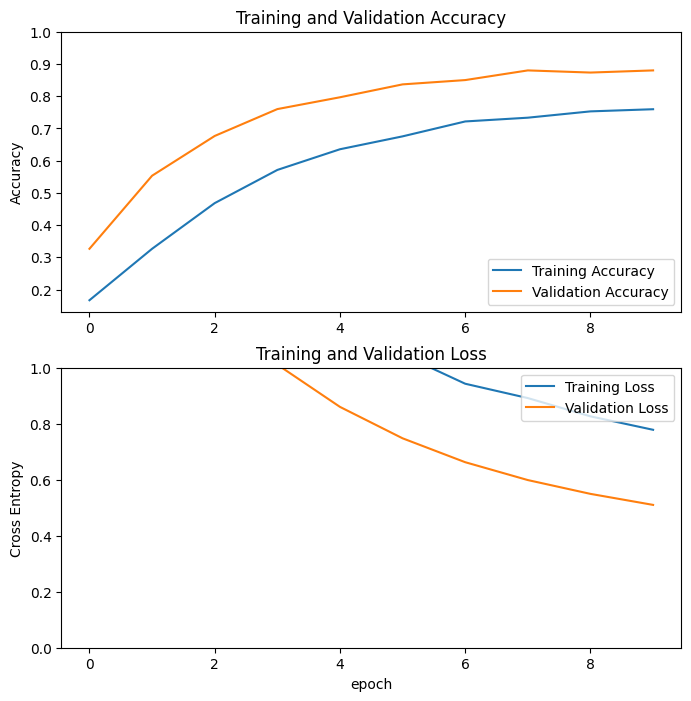

In [10]:

# --- Model Evaluation ---
loss, accuracy = model.evaluate(datatest)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- Plotting Training History ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [11]:

# --- Fine-tuning ---
# Unfreezed the base model
base_model.trainable = True
# Fine-tuned from this layer onwards
fine_tune_at = 100 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompiled the model with a much lower learning rate for fine-tuning
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10), # Typically lower learning rate for fine-tuning
              metrics=['accuracy'])

model.summary()

fine_tune_epochs = 10 # Additional epochs for fine-tuning
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(datatrain,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=datavalid)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 1,874,250 (7.15 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.5662 - loss: 1.3198 - val_accuracy: 0.9000 - val_loss: 0.4484
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.6971 - loss: 0.9819 - val_accuracy: 0.9000 - val_loss: 0.4128
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.7522 - loss: 0.8009 - val_accuracy: 0.9100 - val_loss: 0.3802
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7720 - loss: 0.7433 - val_accuracy: 0.9133 - val_loss: 0.3501
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7986 - loss: 0.6796 - val_accuracy: 0.9233 - val_loss: 0.3196
Epoch 15/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7971 - loss: 0.6177 - val_accuracy: 0.9333 - val_loss: 0.2947
Epoch 16/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8484 - loss: 0.5173 - val_accuracy: 0.9333 - val_loss: 0.2867
Epoch 17/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8473 - loss: 0.5122 - val_accuracy: 0.

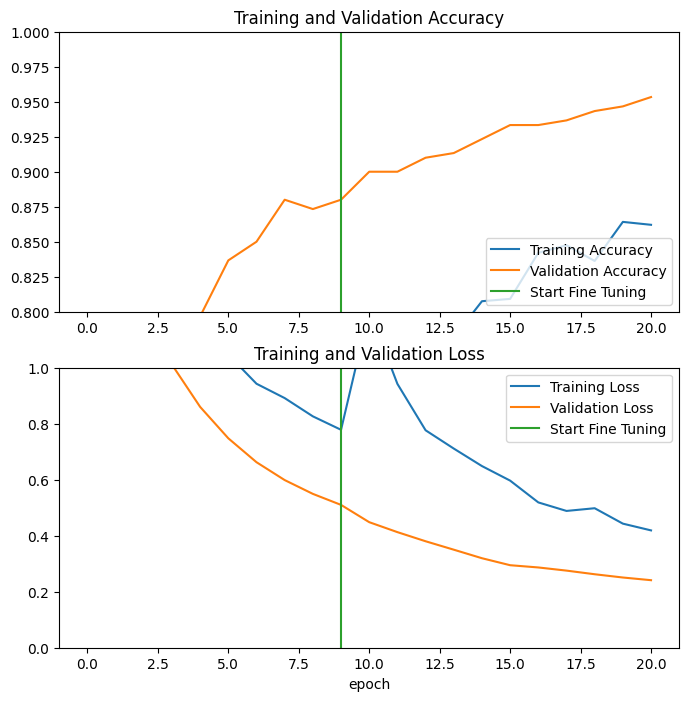

In [12]:

# Plotting full history 
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [13]:

# --- Final Evaluation ---
loss, accuracy = model.evaluate(datatest)
print(f"Final Test Loss: {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 830ms/step - accuracy: 0.9058 - loss: 0.2858
Final Test Loss: 0.2724
Final Test Accuracy: 0.9133


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step 


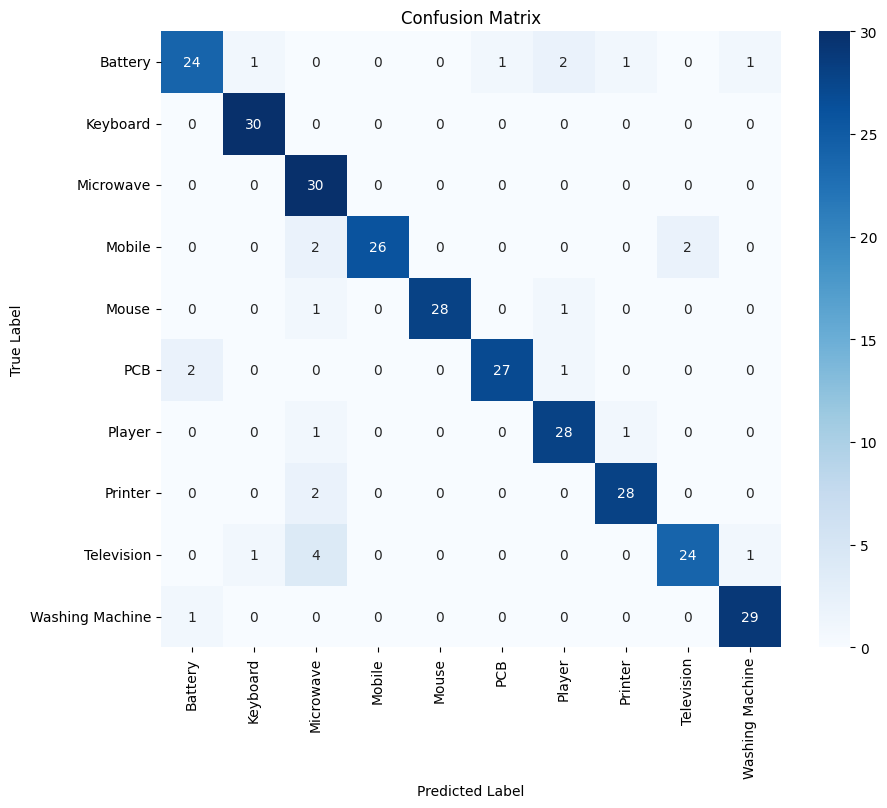

Classification Report:
                  precision    recall  f1-score   support

        Battery       0.89      0.80      0.84        30
       Keyboard       0.94      1.00      0.97        30
      Microwave       0.75      1.00      0.86        30
         Mobile       1.00      0.87      0.93        30
          Mouse       1.00      0.93      0.97        30
            PCB       0.96      0.90      0.93        30
         Player       0.88      0.93      0.90        30
        Printer       0.93      0.93      0.93        30
     Television       0.92      0.80      0.86        30
Washing Machine       0.94      0.97      0.95        30

       accuracy                           0.91       300
      macro avg       0.92      0.91      0.91       300
   weighted avg       0.92      0.91      0.91       300



In [14]:

# --- Confusion Matrix and Classification Report ---
#  predictions on the test set
y_pred_probs = model.predict(datatest)
y_pred = np.argmax(y_pred_probs, axis=1)

#  true labels for the test set
y_true = np.concatenate([y for x, y in datatest], axis=0)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
cr = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
print("Classification Report:\n", cr)

In [15]:

# --- Gradio Interface ---
# This function will use the new MobileNetV2 model for predictions.
def classify_image(img):
    img = img.resize(IMG_SIZE)
    img_array = np.array(img, dtype=np.float32)
    # Used MobileNetV2 specific preprocessing
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    index = np.argmax(prediction)
    class_name = CLASS_NAMES[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="E-Waste Image Classification (MobileNetV2)",
    description="Upload an image of e-waste to classify it into one of 10 categories using a MobileNetV2 model."
)

iface.launch(inbrowser=True)
print("\nGradio interface launched.")

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.



Gradio interface launched.


Traceback (most recent call last):
  File "C:\Users\Samsung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Samsung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Samsung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gradio\blocks.py", line 2220, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Samsung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2k

In [ ]:
# --- Saving the Trained Model ---
model.save('model.keras') # Saves the model in Keras format
print("Model saved successfully as model.keras")

Model saved successfully as model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
